I'm having a look at how to optimise mashed shuffling (for magic reasons!)

In [1]:
%matplotlib inline

import os

import random
import pickle

import json

import numpy as np
from scipy.stats import multivariate_normal as multinomial
from scipy.stats import rv_discrete
from scipy.stats import norm

import pandas as pd

from matplotlib import pyplot
import seaborn

from mtgsdk import Card

A function to return card names from the mtgsdk.

In [2]:
def get_card(card_name):
    print(f'Retrieving: {card_name.title()}.')
    card = Card.where(name=card_name).all()[0]
    print(f'{card_name.title()} retrieved!\n')
    
    return card

A rifle shuffle function.
TODO : make this work for an arbitrary left/right hand drop

In [3]:
def rifle_shuffle(deck_list):
    
    pile = []
    
    a = [a for a in range(28,33)]
    split = random.choices(a)[0]
    
    d = [a for a in range(1,2)]
    
    half1 = deck_list[:split]
    half2 = deck_list[split:]
    
    while (half1 and half2):
        half1_drop_number = random.choices(d)[0]
        half2_drop_number = random.choices(d)[0]
        pile = pile + half1[-half1_drop_number:] + half2[-half2_drop_number:]
        half1 = half1[:-half1_drop_number]
        half2 = half2[:-half2_drop_number]
        
    if half1:
        pile = half1 + pile
        
    if half2:
        pile = half2 + pile
    
    return pile

Overhand shuffling algorithm.

In [4]:
def overhand_shuffle(deck_list):
    a = [x for x in range(100)]
    
    pdf = multinomial.pdf(a, mean=7, cov=6)
    norm_pdf = [(val/sum(pdf)) for val in pdf]
        
    right_hand = deck_list[:]
    left_hand = []
    while len(right_hand) > 7:
        overhand_dist = rv_discrete(a=1, b=len(right_hand), values=(a,norm_pdf))
        drop = overhand_dist.rvs(size=1)[0]
        left_hand = right_hand[:drop] + left_hand
        right_hand = right_hand[drop:]
    left_hand = right_hand + left_hand
    right_hand = []
    
    return left_hand

Function to combine different shuffle types, and examine the hand retrieved from this process.

In [5]:
def create_hand(deck):
    
    hand = [item for item in deck[:7]]

    df = make_dataframe(hand)
    
    hand_types = list(df['type'])
        
    hand_cards = list(df['name'])
                
    hand_qualities = []
    
    for item in list(df['quality']):
        if isinstance(item, str):
            hand_qualities.append([item])
        else:
            hand_qualities.append(item)
            
    hand_qualities = set(flatten_list(hand_qualities))
    
    return hand, hand_types, hand_cards, hand_qualities

In [6]:
def make_dataframe(deck, parameters=['name', 'mana_cost', 
                                     'cmc', 'quality', 'type']):
    
    keys = []
    values = []

    data = []

    for card in deck:
        values = []

        for item in parameters:
            values.append(getattr(card, item))

        data.append(values)

    df = pd.DataFrame(data, columns=parameters)
    
    return df

In [39]:
def shuffle_iterator(deck, search_criteria, iterations=1000,
            overhand_interval=2, basic_shuffle=False):
    
    stats = []
    
    starting_deck = list(deck)

    for i in range(iterations):
        
        if basic_shuffle:
            for i in range(5):
                deck = rifle_shuffle(starting_deck)
                deck = rifle_shuffle(deck)
                deck = overhand_shuffle(deck)
        else:
            deck = list(random.sample(deck, len(deck)))
            
        
        shuffles = 0
        overhand_shuffles = False
        
        hand, hand_types, hand_cards, hand_qualities = create_hand(deck)
        
        while not (search_criteria['quality'].issubset(hand_qualities)
                   and ((hand_types.count('Basic Land — Swamp') == 2) or
                        ((hand_cards.count('Urborg, Tomb of Yawgmoth') == 1) and
                         (hand_types.count('Land') == 2)))):
            
            deck = rifle_shuffle(deck)
            
            hand, hand_types, hand_cards, hand_qualities = create_hand(deck)
        
            shuffles = shuffles + 1
            
            if (shuffles % overhand_interval) == 0:
                deck = overhand_shuffle(deck)

        stats.append({'shuffles': shuffles, 'hand': hand})

    return stats

In [40]:
def flatten_list(list_of_lists):
    flat_list = [item for sublist in list_of_lists for item in sublist]
    
    return flat_list

In [41]:
def make_list(item):
    if not isinstance(item, list):
        item = [item]
    
    return item

In [42]:
deck_json = 'deck.json'
deck_pickle = 'deck.pkl'

if os.path.isfile(deck_pickle):
    with open(deck_pickle, 'rb') as f:
        deck_list = pickle.load(f)
else:
    with open(deck_json, 'rb') as f:
        card_list = json.load(f)

    cards = {}

    for i in card_list.keys():
        name = card_list[i]['name']
        quantity = card_list[i]['quantity']
        quality = card_list[i]['quality']
        card = get_card(name)
        card.quality = quality
        cards[name] = [card, quantity]

    deck_list = []

    for key in cards.keys():
        for i in range(0,cards[key][1]):
            deck_list.append(cards[key][0])
    with open('deck.pkl', 'wb') as f:
        pickle.dump(deck_list, f)

In [43]:
search_terms = {'quality': {'targetted discard', 
                            'win condition',
                            'recurring'}}

In [55]:
deck_random = list(random.sample(deck_list, len(deck_list)))

stats_random = shuffle_iterator(deck_random, search_terms, iterations=1000)

In [56]:
stats_unshuffled = shuffle_iterator(list(deck_list), search_terms, iterations=1000, basic_shuffle=True)

In [57]:
number_of_shuffles_random = [stat['shuffles'] for stat in stats_random]
number_of_shuffles_unshuffled = [stat['shuffles'] for stat in stats_unshuffled]

Modal number of shuffles is: 1
Average number of shuffles is: 30.969


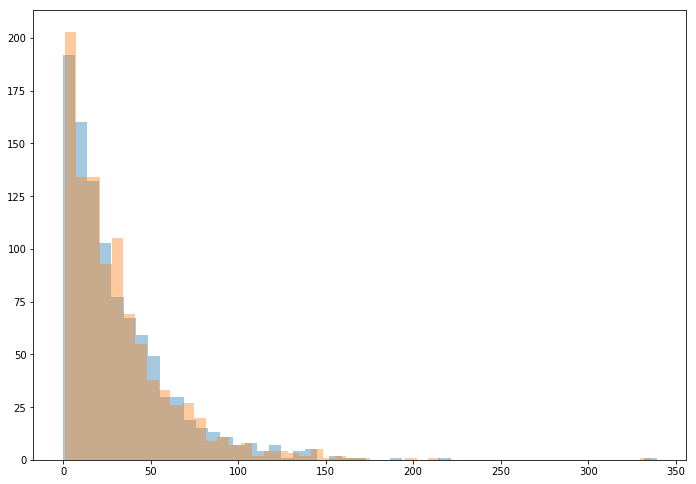

In [58]:
print(f'Modal number of shuffles is: {max(set(number_of_shuffles_random), key=number_of_shuffles_random.count)}')
print(f'Average number of shuffles is: {sum(number_of_shuffles_random)/len(number_of_shuffles_random)}')

q = [number_of_shuffles_random, number_of_shuffles_unshuffled]

b = len(q)

dist = {}

for a in range(b):
    dist[str(a)] = {x:q[a].count(x) for x in q[a]}

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

for a in [number_of_shuffles_random, number_of_shuffles_unshuffled]:
    seaborn.distplot(a, ax=ax, kde=False)

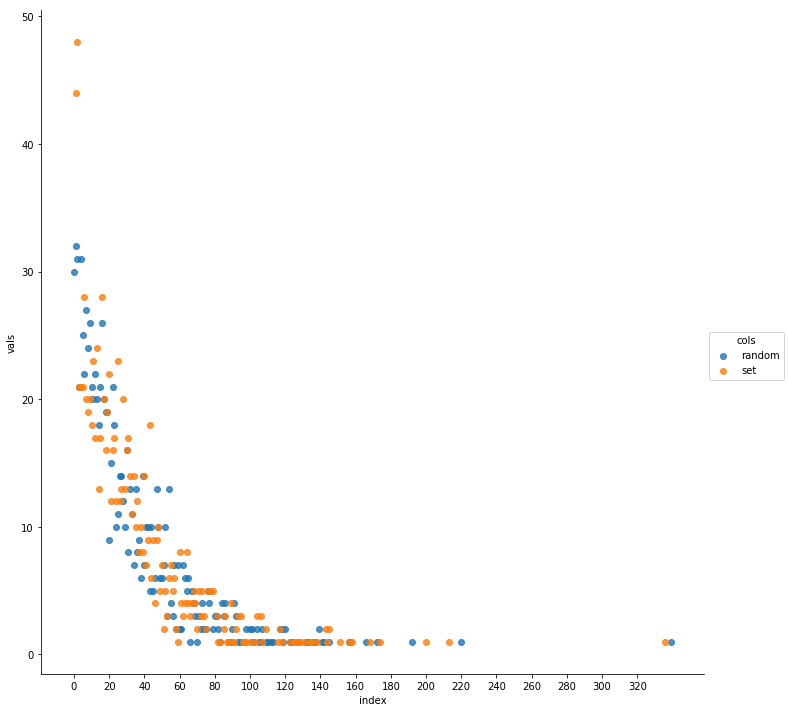

In [71]:
highest_count = max([max(dist[key].keys()) for key in dist.keys()])

data = []

for a in range(b):
    value = []
    index = []
    for i in range(highest_count + 1):
        index.append(i)
        if i in set(dist[str(a)].keys()):
            value.append(dist[str(a)][i])
        else:
            value.append(None)
    
    data.append(value)

test = pd.DataFrame(data, index=['random', 'set']).transpose()

test.reset_index(inplace=True)

test_melt = test.melt('index', var_name='cols', value_name='vals')

g = seaborn.lmplot(x='index', y='vals', hue='cols', 
                   data=test_melt, fit_reg=None,
                   size=10)

g.set(xticks=test['index'][0::20])

In [98]:
for a in ['random', 'set']:
    test[a + ' cumulative'] = pd.Series([sum(filter(None, test[a][:i])) for i in list(test.index)])